# Modelo de clasificación supervisado - Random Forest Classifier


### Importamos librerías

In [2]:
import pandas as pd
import boto3
from sagemaker import get_execution_role
import sagemaker
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

### Se lee el dataset estableciendo conexión con S3-AWS

In [3]:
role = get_execution_role()
bucket = 'ml-supervisado'
data_key = 'sitios_FL_ML.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location, delimiter = ',', low_memory = False)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,latitude,longitude,avg_rating,price,cat__Bakery-Desserts,cat__Delivery-Rest,cat__Restaurant
0,26.641376,-81.940544,5.0,1,0,0,1
1,26.154755,-81.790530,5.0,0,1,0,0
2,29.183271,-81.889960,2.0,1,0,1,0
3,25.779837,-80.239105,5.0,0,0,0,1
4,28.537200,-81.208730,4.0,0,0,1,0


#### Se evalúa la distribución del rating en todo el dataset.Dada la escasez y el desbalanceo que provocaba el rating 1, se lo ha convertido a 2 el modelo se balancee)

Text(0, 0.5, 'Cantidad')

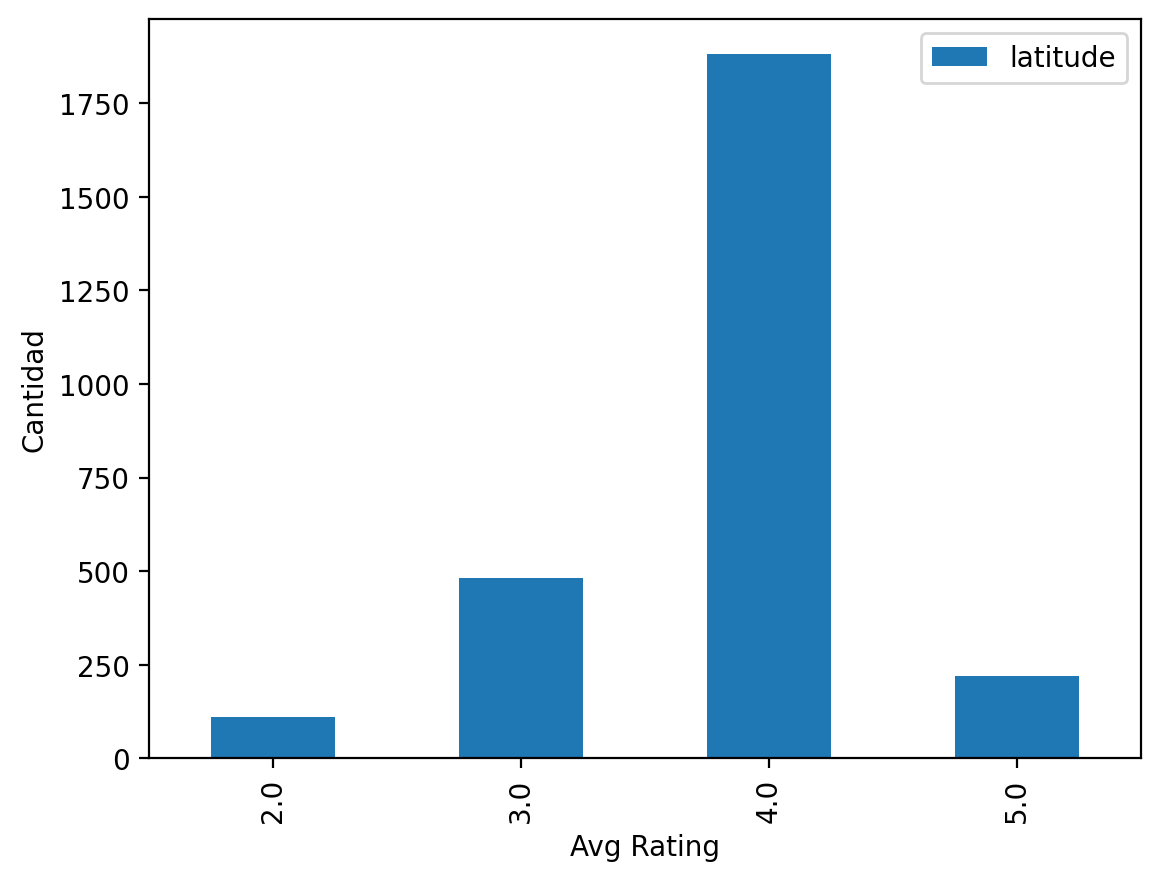

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

df[['avg_rating', 'latitude']].groupby('avg_rating').count().plot(kind='bar')
plt.xlabel('Avg Rating')
plt.ylabel('Cantidad')

#### Se divide el dataset en tabla dato y objetivo, en este caso el objetivo será el rating

In [5]:
X = df[['latitude','longitude', 'price', 'cat__Bakery-Desserts',
       'cat__Delivery-Rest', 'cat__Restaurant']]
y = df['avg_rating']
X.shape, y.shape

((2693, 6), (2693,))

#### Se divide el dataset en entrenamiento y de testeo

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify = y)

#### Se instancia un modelo de Random Forest Classifier y se lo entrena

In [7]:
RFC_modelo = RandomForestClassifier(n_estimators=12, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
RFC_modelo.fit(X_train,y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(n_estimators=12, n_jobs=-1, oob_score=True,
                       random_state=42)

#### Se predice y se evalúan las métricas

In [8]:
y_train_pred = RFC_modelo.predict(X_train)
y_test_pred = RFC_modelo.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.9793644242674371
0.6814814814814815


#### Como se puede ver, el modelo tiene una precisión de 98% en el entrenamiento y 68% en el testeo. 

### Prediccion 

##### Se han elegido 4 lugares de la Florida de manera aleatoria y con caracteristicas aleatorias tambien, los mismos son:
#### Los lugares elegidos son: (zona por la que se encuentran, precio, categoria)
1) Miami            , Precio 1,    Restaurant
2) West Palm Beach  , Precio 0,    Bakery-Desserts
3) Orlando, Precio 2,    Delivery-Rest
4) Tampa            , Precio 1,    Restaurant

#### Se crean los datos con los cuales se quiere predecir

In [12]:
dfp_pred = df.drop('avg_rating',axis=1)
dfp_pred.drop(dfp_pred.index, inplace=True)
dfp_pred.loc[len(dfp_pred.index)] = [25.7744165,-80.1906014,1,0,0,1] # Miami
dfp_pred.loc[len(dfp_pred.index)] = [26.7049467,-80.0543218,0,1,0,0] # West Palm Beach
dfp_pred.loc[len(dfp_pred.index)] = [28.5111468,-81.3721908,2,0,1,0] # Orlando
dfp_pred.loc[len(dfp_pred.index)] = [27.9671268,-82.7822160,1,0,0,1] # Tampa

dfp_pred.head()

,latitude,longitude,price,cat__Bakery-Desserts,cat__Delivery-Rest,cat__Restaurant
0,25.774417,-80.190601,1.0,0.0,0.0,1.0
1,26.704947,-80.054322,0.0,1.0,0.0,0.0
2,28.511147,-81.372191,2.0,0.0,1.0,0.0
3,27.967127,-82.782216,1.0,0.0,0.0,1.0


#### Se predice

In [13]:
y_pred_final = RFC_modelo.predict(df_pred)
y_pred_final

array([4., 5., 4., 5.])

### Los ratings predecidos para los lugares elegidos son:
#### 1) 4
#### 2) 5
#### 3) 4
#### 4) 5